In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240712%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240712T060946Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8d54dfd21b3a07fce4d55abe5fa773b0a4dc0847dfd82a8aed55b1cca1031505fc47ee9d235a789aacc56854b1dae793650ea4dea932692bfab937cf187ae1099e9721737d0bf43d6c8a4150c85e71e3cd4055b8cd1808d02ff2c5e1e9a2972164e2770084002ca3fb8b82725f6182930305beb5bf433a42e1dc0b1b11ef94dca92f4ae633ddb25d70d9aca165216291ac228eda46f3223fcca33174d28ec36e05eeb305d7c30cb3ee802682b3c24fab45b6eeefa437ffabf4dda84f656e82b9892a3ac786ffd49dd9741736de22690300d21f86a10f4c02968f68e55318fc68266714ba0d21aec2d88659a05390cd4b1ae2a4f0c5fa693c76b60506e07ca08b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
sns.set()

train1 = pd.read_csv('/kaggle/input/titanic/train.csv')
test1 = pd.read_csv('/kaggle/input/titanic/test.csv')

train = train1.copy()
test = test1.copy()


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.shape

(891, 12)

In [7]:
test.shape

(418, 11)

In [8]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
train1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
test1.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
feature_selected='Sex'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [ ]:
feature_selected='Pclass'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [ ]:
feature_selected='SibSp'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [ ]:
feature_selected='Parch'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [ ]:
feature_selected='Embarked'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [ ]:
import matplotlib as plt
import seaborn as sns
sns.set()

def drwaing_bar(feature):
    F_survived = train[train['Survived']==1][feature].value_counts()
    F_dead = train[train['Survived']==0][feature].value_counts()
    F_df = pd.DataFrame([F_survived, F_dead])
    F_df.index = ['Survived','Dead']
    F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [12]:
train1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
TDF = pd.DataFrame(train1)

TDF1 = TDF.iloc[:,[0,1,2,4,5,6]]
TDF1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp
0,1,0,3,male,22.0,1
1,2,1,1,female,38.0,1
2,3,1,3,female,26.0,0
3,4,1,1,female,35.0,1
4,5,0,3,male,35.0,0


In [14]:
TDF2 = TDF1.pivot_table('Survived', index='Sex', columns='Pclass', aggfunc='mean')
TDF2

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


<Axes: title={'center': 'Average survivors rates'}, xlabel='Sex'>

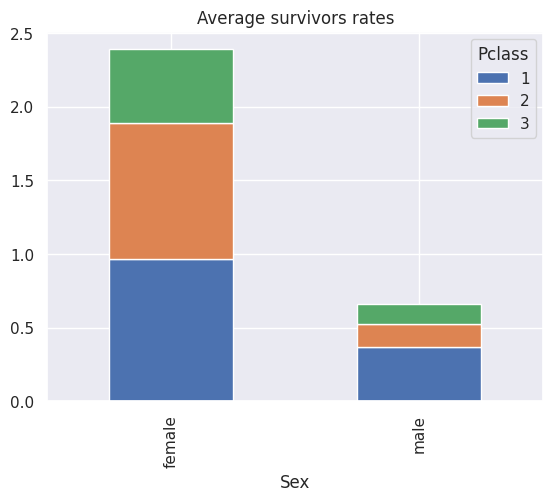

In [15]:
TDF2.plot(kind='bar', stacked=True, title='Average survivors rates')

In [16]:
# 개인/팀 과제) 생존에 영향을 주었을 가능성이 있는 특징에 대해 EDA를 추가적으로 진행하고 가설을 세워 봅시다.
# 1) age/name/cabin ...
# Features : Pclass / Sex / Age / SibSp / Parch / Ticket / Fare / Cabin / Embarked



In [17]:
# 개인/팀 과제) Name에 포함된 타이틀(직업)의 의미를 분석해봅시다.
# 1) 연령/성별/신분의 사회적 위치/경제적 여건/영향력 등

In [18]:
train = train1

train_test_data = [train, test]

for two_data in train_test_data:
    two_data['Title'] = two_data['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)

In [19]:
train['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [20]:
test['Title'].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [21]:
train.Title.value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [22]:
test.Title.value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [23]:
pd.crosstab(train['Title'],train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [24]:
pd.crosstab(test['Title'],test['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------



In [ ]:
# train.groupby('Title').mean()['Survived']

In [25]:
train.groupby('Title')['Survived'].apply(lambda x: x.mean())

Title
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [26]:
train.groupby('Title').mean(numeric_only=True)['Survived']

Title
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [27]:
title_mapping = {
    'Mr': 0, 'Rev': 0, 'Don': 0, 'Capt': 0, 'Jonkheer': 0,
    'Miss': 1, 'Ms': 1,
    'Mrs': 2, 'Lady': 2, 'Dona': 2, 'Mme': 2, 'Countess': 2,
    'Master': 3, 'Dr': 3, 'Mlle': 3,
    'Col': 4, 'Major': 4, 'Sir': 4
}

for two_data in train_test_data:
    two_data['Title'] = two_data['Title'].map(title_mapping)


In [28]:
train['Age'].fillna(train.groupby('Title')['Age'].transform('mean'), inplace=True)
test['Age'].fillna(test.groupby('Title')['Age'].transform('mean'), inplace=True)

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [30]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2


In [31]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [32]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0


In [33]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,2


<Axes: >

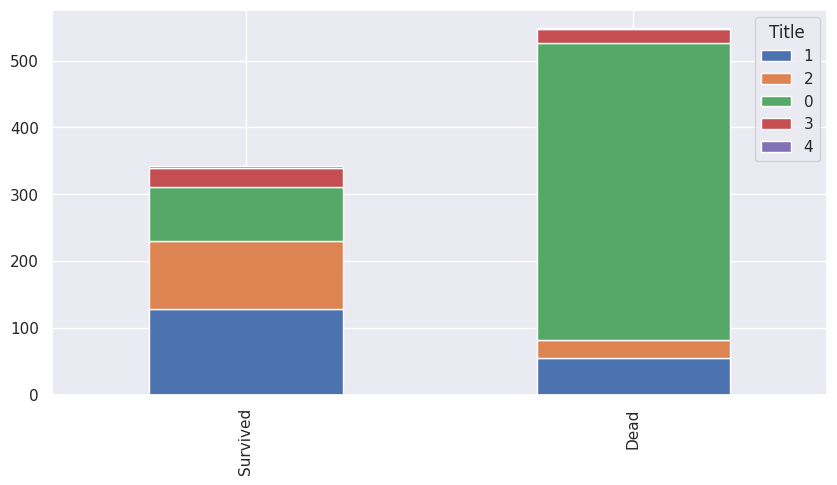

In [34]:
feature_selected='Title'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

In [35]:
sex_mapping = {'male':0, 'female':1}
for two_data in train_test_data:
    two_data['Sex']=two_data['Sex'].map(sex_mapping)

In [36]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,1,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,0,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,0,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,1,22.0,1,1,3101298,12.2875,NaN,S,2


In [37]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Title        891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [39]:
train['Age'].fillna(train.groupby('Title')['Age'].transform('mean'), inplace=True)
test['Age'].fillna(test.groupby('Title')['Age'].transform('mean'), inplace=True)

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Title        891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [41]:
train['Age'].describe()

count    891.000000
mean      29.785460
std       13.248040
min        0.420000
25%       21.816327
50%       30.000000
75%       35.873874
max       80.000000
Name: Age, dtype: float64

In [42]:
train['Age'].value_counts()

Age
32.652334    119
21.816327     36
24.000000     30
22.000000     27
18.000000     26
            ... 
14.500000      1
70.500000      1
12.000000      1
36.500000      1
74.000000      1
Name: count, Length: 92, dtype: int64

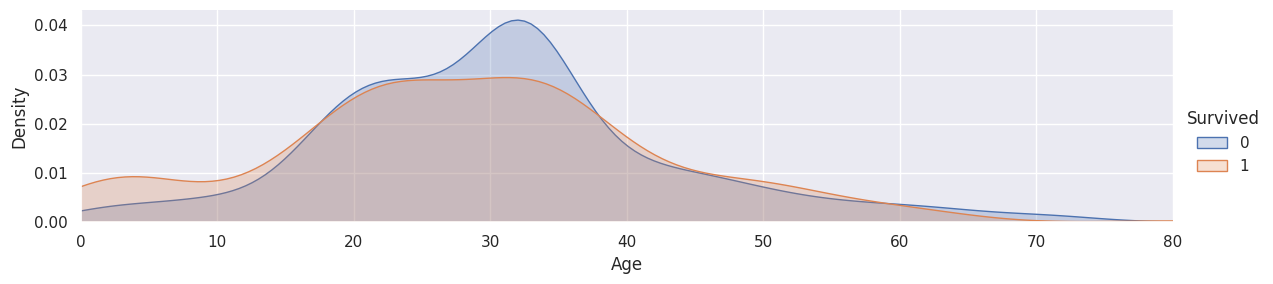

In [45]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', fill=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

In [46]:
for two_data in train_test_data:
    two_data.loc[two_data['Age'] <=18, 'Age']=0
    two_data.loc[(two_data['Age']>18)&(two_data['Age']<=35), 'Age']=1
    two_data.loc[(two_data['Age']>35)&(two_data['Age']<=45), 'Age']=2
    two_data.loc[(two_data['Age']>45)&(two_data['Age']<=60), 'Age']=3
    two_data.loc[(two_data['Age']>60), 'Age']=4

In [47]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,2.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,1.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,1.0,0,0,373450,8.0500,NaN,S,0


In [48]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,1.0,0,0,330911,7.8292,NaN,Q,0
1,893,3,1,3.0,1,0,363272,7.0000,NaN,S,2
2,894,2,0,4.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,0,1.0,0,0,315154,8.6625,NaN,S,0
4,896,3,1,1.0,1,1,3101298,12.2875,NaN,S,2


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Title        891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


<Axes: >

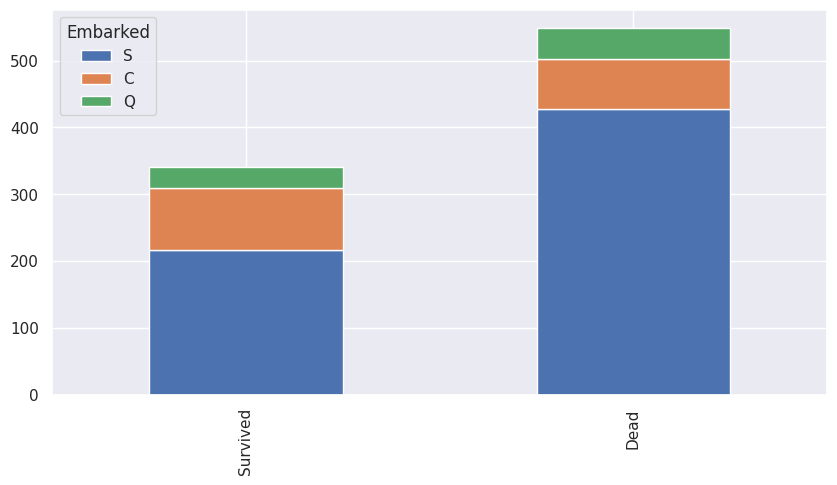

In [50]:
feature_selected='Embarked'

F_survived = train[train['Survived']==1][feature_selected].value_counts()
F_dead = train[train['Survived']==0][feature_selected].value_counts()
F_df = pd.DataFrame([F_survived, F_dead])
F_df.index = ['Survived', 'Dead']
F_df.plot(kind='bar', stacked=True, figsize=(10,5))

<Axes: >

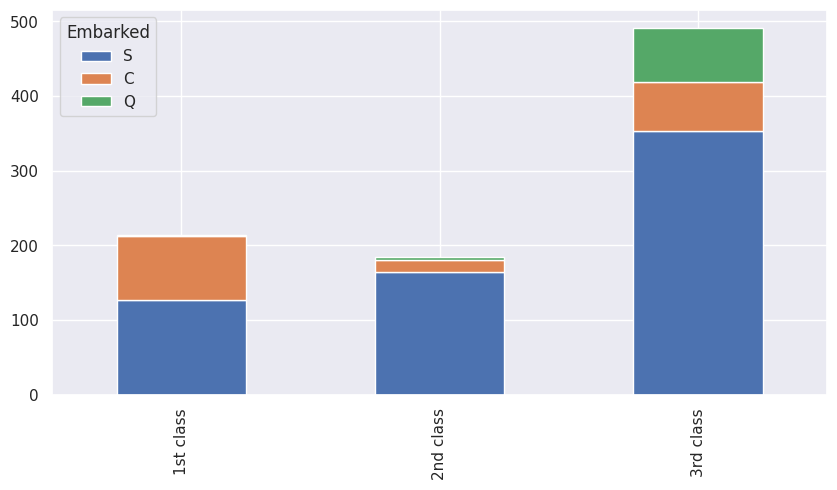

In [51]:
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10,5))

In [52]:
for two_data in train_test_data:
    two_data['Embarked'] = two_data['Embarked'].fillna('S')

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     891 non-null    object 
 11  Title        891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    object 
 10  Title        418 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


In [55]:
embarked_mapping = {'S':0, 'C':1, 'Q':2}

for two_data in train_test_data:
    two_data['Embarked'] = two_data['Embarked'].map(embarked_mapping)

In [56]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,2.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,1.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,1.0,0,0,373450,8.0500,NaN,0,0


In [57]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,1.0,0,0,330911,7.8292,NaN,2,0
1,893,3,1,3.0,1,0,363272,7.0000,NaN,0,2
2,894,2,0,4.0,0,0,240276,9.6875,NaN,2,0
3,895,3,0,1.0,0,0,315154,8.6625,NaN,0,0
4,896,3,1,1.0,1,1,3101298,12.2875,NaN,0,2


In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    int64  
 10  Title        418 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 36.0+ KB


In [59]:
train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'), inplace=True)
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         418 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    int64  
 10  Title        418 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 36.0+ KB


In [62]:
train['Fare'].max()

512.3292

(0.0, 300.0)

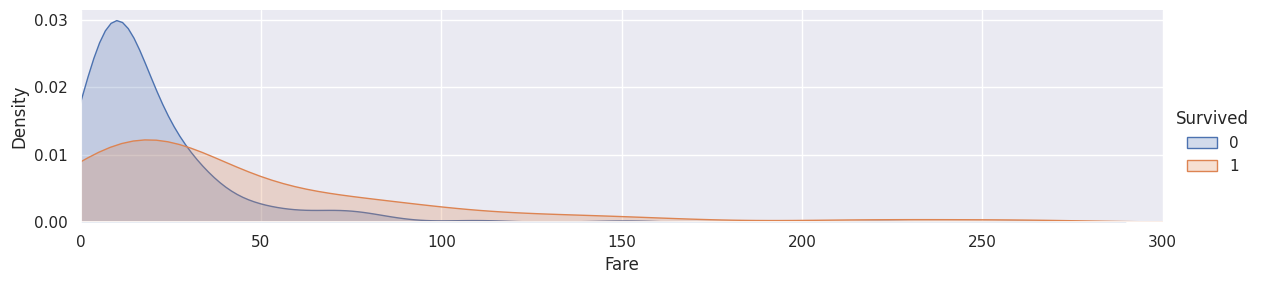

In [70]:
import matplotlib.pyplot as plt
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', fill=True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.xlim(0,300)

In [71]:
for two_data in train_test_data:
    two_data.loc[two_data['Fare'] <=5, 'Fare']=0
    two_data.loc[(two_data['Fare']>5)&(two_data['Fare']<=15), 'Fare']=1
    two_data.loc[(two_data['Fare']>15)&(two_data['Fare']<=30), 'Fare']=2
    two_data.loc[(two_data['Fare']>30)&(two_data['Fare']<=100), 'Fare']=3
    two_data.loc[(two_data['Fare']>100), 'Fare']=4

In [72]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,1.0,NaN,0,0
1,2,1,1,1,2.0,1,0,PC 17599,3.0,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,1.0,NaN,0,1
3,4,1,1,1,1.0,1,0,113803,3.0,C123,0,2
4,5,0,3,0,1.0,0,0,373450,1.0,NaN,0,0


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     891 non-null    int64  
 11  Title        891 non-null    int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 83.7+ KB


In [74]:
train['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [75]:
train['Cabin'].isnull().sum()

687

In [76]:
for two_data in train_test_data:
    two_data['Cabin']=two_data['Cabin'].str[:1]

train['Cabin'].value_counts()

Cabin
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

In [77]:
cabin_mapping = {'A':2, 'B':2, 'C':2, 'T':2,
                'D':1, 'G':1,
                'E':0, 'F':0}

for two_data in train_test_data:
    two_data['Cabin'] = two_data['Cabin'].map(cabin_mapping)

In [78]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,1.0,NaN,0,0
1,2,1,1,1,2.0,1,0,PC 17599,3.0,2.0,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,1.0,NaN,0,1
3,4,1,1,1,1.0,1,0,113803,3.0,2.0,0,2
4,5,0,3,0,1.0,0,0,373450,1.0,NaN,0,0


In [79]:
train['Cabin'].fillna(train.groupby('Pclass')['Cabin'].transform('median'), inplace=True)
test['Cabin'].fillna(test.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,1.0,0.0,0,0
1,2,1,1,1,2.0,1,0,PC 17599,3.0,2.0,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,1.0,0.0,0,1
3,4,1,1,1,1.0,1,0,113803,3.0,2.0,0,2
4,5,0,3,0,1.0,0,0,373450,1.0,0.0,0,0


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    float64
 10  Embarked     891 non-null    int64  
 11  Title        891 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 83.7+ KB


In [81]:
train['Familysize'] = train['SibSp'] + train['Parch']+1
test['Familysize'] = train['SibSp'] + test['Parch']+1

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Familysize
0,1,0,3,0,1.0,1,0,A/5 21171,1.0,0.0,0,0,2
1,2,1,1,1,2.0,1,0,PC 17599,3.0,2.0,1,2,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,1.0,0.0,0,1,1
3,4,1,1,1,1.0,1,0,113803,3.0,2.0,0,2,2
4,5,0,3,0,1.0,0,0,373450,1.0,0.0,0,0,1


In [82]:
for two_data in train_test_data:
    two_data.loc[two_data['Familysize'] <=1, 'Familysize']=0
    two_data.loc[(two_data['Familysize']>1)&(two_data['Familysize']<=2), 'Familysize']=1
    two_data.loc[(two_data['Familysize']>2)&(two_data['Familysize']<=5), 'Familysize']=2
    two_data.loc[(two_data['Familysize']>5), 'Familysize']=3

In [83]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Familysize
0,1,0,3,0,1.0,1,0,A/5 21171,1.0,0.0,0,0,1
1,2,1,1,1,2.0,1,0,PC 17599,3.0,2.0,1,2,1
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,1.0,0.0,0,1,0
3,4,1,1,1,1.0,1,0,113803,3.0,2.0,0,2,1
4,5,0,3,0,1.0,0,0,373450,1.0,0.0,0,0,0


In [84]:
feature_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(feature_drop, axis=1)
train = train.drop('PassengerId', axis=1)

test = test.drop(feature_drop, axis=1)

train_x = train.drop('Survived', axis =1)
train_y = train['Survived']

In [85]:
train_x.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Familysize
0,3,0,1.0,1.0,0.0,0,0,1
1,1,1,2.0,3.0,2.0,1,2,1
2,3,1,1.0,1.0,0.0,0,1,0
3,1,1,1.0,3.0,2.0,0,2,1
4,3,0,1.0,1.0,0.0,0,0,0


In [86]:
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [87]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Familysize
0,892,3,0,1.0,1.0,0.0,2,0,1.0
1,893,3,1,3.0,1.0,0.0,0,2,1.0
2,894,2,0,4.0,1.0,0.0,2,0,0.0
3,895,3,0,1.0,1.0,0.0,0,0,1.0
4,896,3,1,1.0,1.0,0.0,0,2,1.0


In [88]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Familysize
0,892,3,0,1.0,1.0,0.0,2,0,1.0
1,893,3,1,3.0,1.0,0.0,0,2,1.0
2,894,2,0,4.0,1.0,0.0,2,0,0.0
3,895,3,0,1.0,1.0,0.0,0,0,1.0
4,896,3,1,1.0,1.0,0.0,0,2,1.0


In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [90]:
K_clf = KNeighborsClassifier(n_neighbors =50)
scoring1 = 'accuracy'
score = cross_val_score(K_clf, train_x,  train_y, cv=k_fold, scoring = scoring1)
print(round(np.mean(score)*100,2))

78.9


In [91]:
d_clf = DecisionTreeClassifier()
scoring1 = 'accuracy'
score = cross_val_score(d_clf, train_x,  train_y, cv=k_fold, scoring = scoring1)
print(round(np.mean(score)*100,2))

80.36


In [92]:
r_clf = RandomForestClassifier(n_estimators =15)
scoring1 = 'accuracy'
score = cross_val_score(r_clf, train_x,  train_y, cv=k_fold, scoring = scoring1)
print(round(np.mean(score)*100,2))

81.48


In [93]:
g_clf = GaussianNB()
scoring1 = 'accuracy'
score = cross_val_score(g_clf, train_x,  train_y, cv=k_fold, scoring = scoring1)
print(round(np.mean(score)*100,2))

75.64


In [94]:
s_clf = SVC()
scoring1 = 'accuracy'
score = cross_val_score(s_clf, train_x,  train_y, cv=k_fold, scoring = scoring1)
print(round(np.mean(score)*100,2))

82.94


In [95]:
s_clf.fit(train_x, train_y)

test_x=test.drop('PassengerId', axis=1).copy()
prediction = s_clf.predict(test_x)

submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':prediction})
submission.to_csv('submission.csv', index=False)
